# Architecture Diagrams: FNN Cone, GRU, OLS Regression

Visual representations of the three deep hedging models used in the MSc thesis.

- **FNN**: Cone architecture (narrowing hidden layers), CELU activations, 1 output → sigmoid allocation
- **GRU**: Pre-MLP → stacked GRU → head MLP, d_traded=2 outputs → direct hedge positions
- **OLS Regression**: Closed-form linear model, d_traded=2 outputs → direct hedge positions

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import numpy as np

## 1. FNN Cone Hedger

Narrowing "cone" feedforward network. At each time step $k$, maps features $X_k \in \mathbb{R}^8$ (log-prices, time-to-maturity, signatures) to a **single** logit $h_k$. Portfolio allocation via $w_1 = \sigma(h_k)$, $w_2 = 1 - w_1$.

**Architecture**: `start_width → start_width//2 → ... → 4 → 1`  
**Block**: Linear → LayerNorm → CELU → Dropout  
**Output head**: Linear(last_width, 1) — identity (no activation)

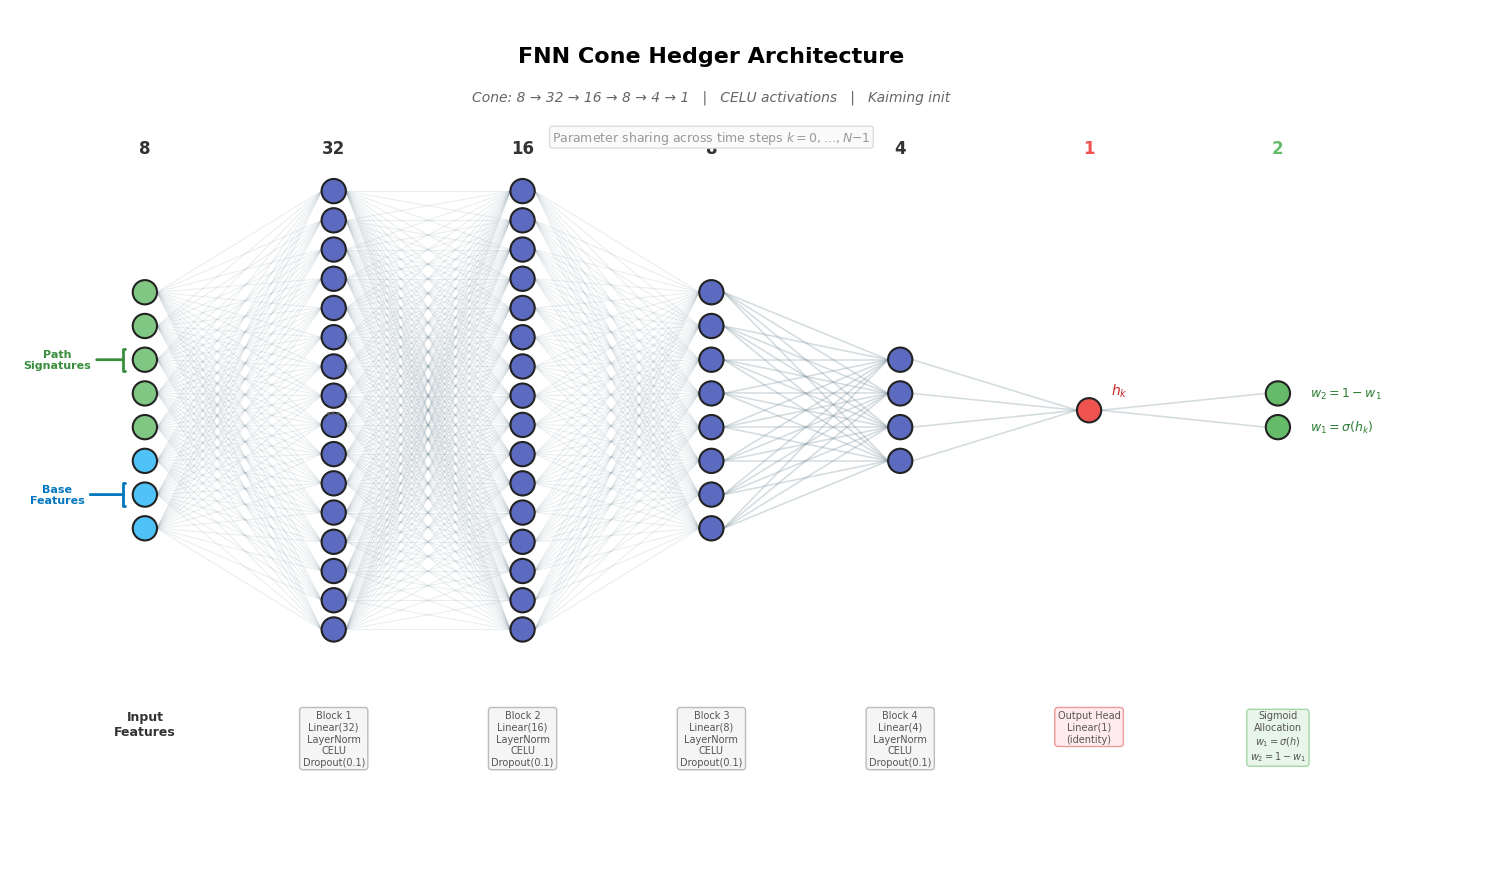

In [2]:
def draw_fnn_cone(save_path=None, start_width=32):
    """Draw FNN Cone hedger with individual neurons and connections.
    
    Style: neuron circles, grouped inputs, connection lines, block labels.
    Cone: 8 -> 32 -> 16 -> 8 -> 4 -> 1 (-> sigmoid allocation)
    """
    # Compute cone widths
    widths = []
    w = start_width
    while w >= 4:
        widths.append(w)
        w = w // 2

    # Layer sizes: input, hidden cone layers, output head, sigmoid output
    input_size = 8
    output_size = 1
    alloc_size = 2
    layer_sizes = [input_size] + widths + [output_size, alloc_size]
    n_layers = len(layer_sizes)

    # Max neurons to draw per layer (show dots for large layers)
    max_draw = 16  # draw up to this many, with dots for the rest

    fig, ax = plt.subplots(figsize=(20, 9))

    # Spacing
    x_spacing = 2.8
    total_width = (n_layers - 1) * x_spacing
    x_start = 1.5
    y_center = 4.0
    neuron_radius = 0.18
    max_y_span = 6.5

    # Colours
    c_base = '#4FC3F7'       # light blue - base features
    c_sig = '#81C784'        # green - signatures
    c_hidden = '#5C6BC0'     # indigo - hidden
    c_output = '#EF5350'     # red - output
    c_alloc = '#66BB6A'      # green - allocation
    c_conn = '#78909C'       # stronger grey connections
    c_conn_out = '#90A4AE'

    def get_neuron_positions(layer_idx, size):
        """Get (x, [y1, y2, ...]) positions for neurons in a layer."""
        x = x_start + layer_idx * x_spacing
        draw_n = min(size, max_draw)
        if draw_n <= 1:
            return x, [y_center]
        spacing = min(0.5, max_y_span / (draw_n - 1))
        total_h = (draw_n - 1) * spacing
        ys = [y_center - total_h/2 + i * spacing for i in range(draw_n)]
        return x, ys

    all_positions = []
    for i, size in enumerate(layer_sizes):
        x, ys = get_neuron_positions(i, size)
        all_positions.append((x, ys, size))

    # --- Draw connections (THICKER) ---
    for l in range(n_layers - 1):
        x1, ys1, s1 = all_positions[l]
        x2, ys2, s2 = all_positions[l + 1]
        alpha = 0.15 if max(s1, s2) > 10 else 0.3
        lw = 0.8 if max(s1, s2) > 10 else 1.2
        for y1 in ys1:
            for y2 in ys2:
                ax.plot([x1 + neuron_radius, x2 - neuron_radius], [y1, y2],
                        color=c_conn, linewidth=lw, alpha=alpha, zorder=0)

    # --- Draw neurons (THICKER edges) ---
    for l, (x, ys, size) in enumerate(all_positions):
        draw_n = min(size, max_draw)
        show_dots = size > max_draw

        if l == 0:
            # Input layer: colour-code base vs signatures
            colours = [c_base] * 3 + [c_sig] * 5
        elif l <= len(widths):
            colours = [c_hidden] * draw_n
        elif l == len(widths) + 1:
            colours = [c_output] * draw_n
        else:
            colours = [c_alloc] * draw_n

        for i, y in enumerate(ys):
            circle = plt.Circle((x, y), neuron_radius, facecolor=colours[min(i, len(colours)-1)],
                               edgecolor='#222', linewidth=1.5, zorder=3)
            ax.add_patch(circle)

        # Dots indicator for truncated layers
        if show_dots:
            mid_y = y_center
            ax.text(x, mid_y, '...', ha='center', va='center', fontsize=10,
                    fontweight='bold', color='#555', zorder=4)

    # --- Layer labels (bottom) ---
    label_y = y_center - max_y_span/2 - 1.2
    # Input
    x0 = all_positions[0][0]
    ax.text(x0, label_y, 'Input\nFeatures', ha='center', va='top',
            fontsize=9, fontweight='bold', color='#333')

    # Hidden blocks
    for i, width in enumerate(widths):
        xh = all_positions[i + 1][0]
        ax.text(xh, label_y, f'Block {i+1}\nLinear({width})\nLayerNorm\nCELU\nDropout(0.1)',
                ha='center', va='top', fontsize=7, color='#555',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='#F5F5F5',
                         edgecolor='#BBB', linewidth=1.0))

    # Output head
    x_out = all_positions[len(widths) + 1][0]
    ax.text(x_out, label_y, 'Output Head\nLinear(1)\n(identity)',
            ha='center', va='top', fontsize=7, color='#555',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#FFEBEE',
                     edgecolor='#EF9A9A', linewidth=1.0))

    # Sigmoid allocation
    x_alloc = all_positions[-1][0]
    ax.text(x_alloc, label_y, 'Sigmoid\nAllocation\n$w_1=\\sigma(h)$\n$w_2=1-w_1$',
            ha='center', va='top', fontsize=7, color='#555',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='#E8F5E9',
                     edgecolor='#A5D6A7', linewidth=1.0))

    # --- Size labels above each layer ---
    top_y = y_center + max_y_span/2 + 0.5
    for l, (x, ys, size) in enumerate(all_positions):
        if l == 0:
            lbl = '8'
        elif l <= len(widths):
            lbl = str(widths[l-1])
        elif l == len(widths) + 1:
            lbl = '1'
        else:
            lbl = '2'
        c = c_output if l == len(widths) + 1 else ('#333' if l <= len(widths) else c_alloc)
        ax.text(x, top_y, lbl, ha='center', va='bottom', fontsize=12,
                fontweight='bold', color=c)

    # --- Input feature group labels (THICKER brackets) ---
    x_inp = all_positions[0][0]
    ys_inp = all_positions[0][1]
    # Base features (first 3)
    base_mid = np.mean(ys_inp[:3])
    ax.annotate('Base\nFeatures',
                xy=(x_inp - neuron_radius - 0.1, base_mid),
                xytext=(x_inp - 1.3, base_mid),
                ha='center', va='center', fontsize=8, color='#0277BD', fontweight='bold',
                arrowprops=dict(arrowstyle='-[', color='#0277BD', lw=2.0))
    # Signatures (last 5)
    sig_mid = np.mean(ys_inp[3:])
    ax.annotate('Path\nSignatures',
                xy=(x_inp - neuron_radius - 0.1, sig_mid),
                xytext=(x_inp - 1.3, sig_mid),
                ha='center', va='center', fontsize=8, color='#388E3C', fontweight='bold',
                arrowprops=dict(arrowstyle='-[', color='#388E3C', lw=2.0))

    # --- Output labels ---
    x_alloc_pos = all_positions[-1][0]
    ys_alloc = all_positions[-1][1]
    ax.text(x_alloc_pos + neuron_radius + 0.3, ys_alloc[0], '$w_1 = \\sigma(h_k)$',
            ha='left', va='center', fontsize=9, fontweight='bold', color='#2E7D32')
    ax.text(x_alloc_pos + neuron_radius + 0.3, ys_alloc[1], '$w_2 = 1 - w_1$',
            ha='left', va='center', fontsize=9, fontweight='bold', color='#2E7D32')

    # h_k label on output neuron
    x_h = all_positions[-2][0]
    ys_h = all_positions[-2][1]
    ax.text(x_h + neuron_radius + 0.15, ys_h[0] + 0.3, '$h_k$',
            ha='left', va='center', fontsize=10, fontweight='bold', color='#C62828')

    # --- Title ---
    title_x = x_start + total_width / 2
    ax.text(title_x, top_y + 1.5,
            f'FNN Cone Hedger Architecture',
            ha='center', va='center', fontsize=16, fontweight='bold')
    widths_str = ' → '.join(str(w) for w in widths)
    ax.text(title_x, top_y + 0.9,
            f'Cone: 8 → {widths_str} → 1   |   CELU activations   |   Kaiming init',
            ha='center', va='center', fontsize=10, color='#666', style='italic')

    # Parameter sharing note
    ax.text(title_x, top_y + 0.3,
            'Parameter sharing across time steps $k = 0, \\ldots, N{-}1$',
            ha='center', va='center', fontsize=9, color='#999',
            bbox=dict(boxstyle='round,pad=0.2', facecolor='#FAFAFA',
                     edgecolor='#DDD', linewidth=1.0))

    ax.set_xlim(-0.5, x_start + total_width + 3)
    ax.set_ylim(label_y - 2.5, top_y + 2.2)
    ax.set_aspect('equal')
    ax.axis('off')
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_fnn_cone('Figures/fnn_cone_architecture.png', start_width=32)

## 2. GRU Hedger

Pre-MLP $\to$ stacked GRU $\to$ Head MLP. Processes the feature sequence causally and outputs **direct hedge positions** $h_k \in \mathbb{R}^2$ at each step. Gains: $g_k = h_k \odot \Delta S_k$.

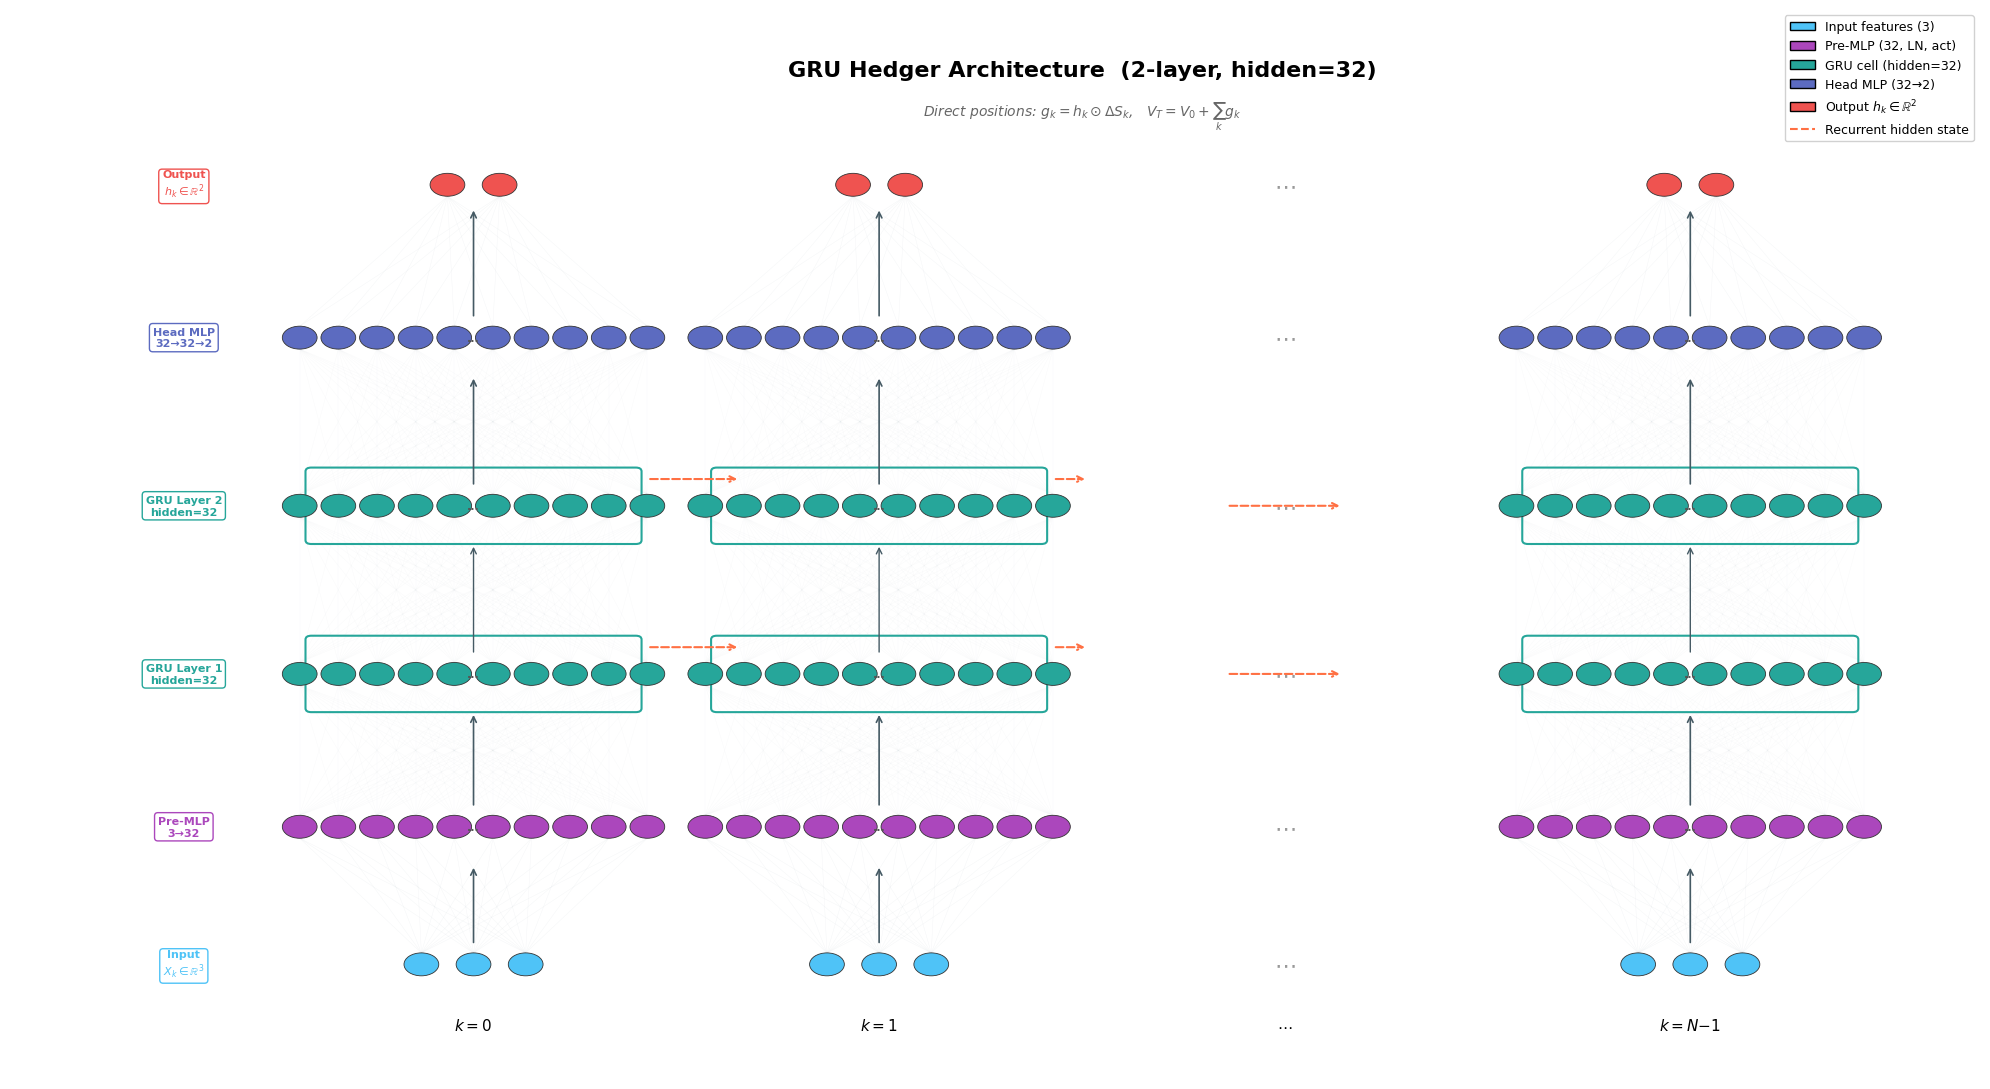

In [3]:
def draw_gru(save_path=None, num_layers=2, hidden_size=32):
    """Draw GRU hedger with neuron-level detail.
    
    Shows unrolled time steps with Pre-MLP, stacked GRU cells, Head MLP.
    Input 3 -> Pre-MLP -> hidden -> GRU layers -> Head -> 2 direct positions.
    """
    fig, ax = plt.subplots(figsize=(20, 11))

    # Layout parameters
    col_spacing = 3.5
    time_labels = ['$k=0$', '$k=1$', '$\\cdots$', '$k=N{-}1$']
    n_cols = len(time_labels)

    # Vertical positions for each stage
    input_y = 0.0
    pre_y = 1.8
    gru_ys = [pre_y + 2.0 + i * 2.2 for i in range(num_layers)]
    head_y = gru_ys[-1] + 2.2
    output_y = head_y + 2.0

    neuron_r = 0.15
    x_start = 2.0

    # Colours
    c_input = '#4FC3F7'
    c_pre = '#AB47BC'
    c_gru = '#26A69A'
    c_head = '#5C6BC0'
    c_output = '#EF5350'
    c_conn = '#B0BEC5'
    c_recur = '#FF7043'

    def draw_neuron_row(ax, cx, cy, n, max_n, colour, label=None):
        """Draw a horizontal row of neurons centered at (cx, cy)."""
        draw_n = min(n, max_n)
        spacing = min(0.45, 3.0 / max(draw_n - 1, 1))
        total_w = (draw_n - 1) * spacing
        xs = [cx - total_w/2 + i * spacing for i in range(draw_n)]
        for x in xs:
            circle = plt.Circle((x, cy), neuron_r, facecolor=colour,
                               edgecolor='#333', linewidth=0.6, zorder=3)
            ax.add_patch(circle)
        if n > max_n:
            ax.text(cx, cy, '...', ha='center', va='center', fontsize=8,
                    fontweight='bold', color='#555', zorder=4)
        if label:
            ax.text(cx, cy - 0.6, label, ha='center', va='top', fontsize=7,
                    color='#555')
        return xs

    def draw_vertical_connections(ax, xs_from, y_from, xs_to, y_to, colour=c_conn, alpha=0.1):
        """Draw connections between two neuron rows."""
        for x1 in xs_from:
            for x2 in xs_to:
                ax.plot([x1, x2], [y_from + neuron_r, y_to - neuron_r],
                        color=colour, linewidth=0.3, alpha=alpha, zorder=0)

    for col_idx in range(n_cols):
        cx = x_start + col_idx * col_spacing
        is_dots = (col_idx == 2)

        if is_dots:
            # Just draw dots at each level
            for y in [input_y, pre_y] + gru_ys + [head_y, output_y]:
                ax.text(cx, y, '$\\cdots$', ha='center', va='center',
                        fontsize=16, color='#999', fontweight='bold')
            ax.text(cx, input_y - 0.8, time_labels[col_idx],
                    ha='center', va='center', fontsize=11)
            # Recurrent arrows through dots
            for gy in gru_ys:
                ax.annotate('', xy=(cx + 0.5, gy),
                            xytext=(cx - 0.5, gy),
                            arrowprops=dict(arrowstyle='->', color=c_recur,
                                            lw=1.5, linestyle='--'))
            continue

        # --- Input neurons ---
        xs_inp = draw_neuron_row(ax, cx, input_y, 3, 3, c_input)

        # Arrow input -> pre-MLP
        ax.annotate('', xy=(cx, pre_y - 0.5), xytext=(cx, input_y + neuron_r + 0.1),
                    arrowprops=dict(arrowstyle='->', color='#455A64', lw=1.2))

        # --- Pre-MLP neurons ---
        xs_pre = draw_neuron_row(ax, cx, pre_y, hidden_size, 10, c_pre)
        draw_vertical_connections(ax, xs_inp, input_y, xs_pre, pre_y, alpha=0.15)

        # Arrow pre-MLP -> GRU 1
        ax.annotate('', xy=(cx, gru_ys[0] - 0.5), xytext=(cx, pre_y + neuron_r + 0.1),
                    arrowprops=dict(arrowstyle='->', color='#455A64', lw=1.2))

        # --- GRU layers ---
        prev_xs = xs_pre
        prev_y = pre_y
        for layer_idx in range(num_layers):
            gy = gru_ys[layer_idx]
            xs_gru = draw_neuron_row(ax, cx, gy, hidden_size, 10, c_gru)
            draw_vertical_connections(ax, prev_xs, prev_y, xs_gru, gy, alpha=0.08)

            # GRU cell box outline
            gru_w = 2.8
            gru_h = 0.9
            rect = FancyBboxPatch((cx - gru_w/2, gy - gru_h/2), gru_w, gru_h,
                                  boxstyle='round,pad=0.05', facecolor='none',
                                  edgecolor=c_gru, linewidth=1.5, linestyle='-', zorder=2)
            ax.add_patch(rect)

            # Recurrent arrow to next time step
            if col_idx < n_cols - 1:
                next_cx = x_start + (col_idx + 1) * col_spacing
                if col_idx + 1 == 2:  # next is dots
                    next_cx = x_start + 2 * col_spacing - 0.5
                ax.annotate('',
                            xy=(next_cx - 1.2, gy + 0.35),
                            xytext=(cx + gru_w/2 + 0.1, gy + 0.35),
                            arrowprops=dict(arrowstyle='->', color=c_recur,
                                            lw=1.5, linestyle='--'))

            if layer_idx < num_layers - 1:
                ax.annotate('', xy=(cx, gru_ys[layer_idx + 1] - 0.5),
                            xytext=(cx, gy + neuron_r + 0.1),
                            arrowprops=dict(arrowstyle='->', color='#455A64', lw=1.0))

            prev_xs = xs_gru
            prev_y = gy

        # Arrow last GRU -> Head
        ax.annotate('', xy=(cx, head_y - 0.5), xytext=(cx, gru_ys[-1] + neuron_r + 0.1),
                    arrowprops=dict(arrowstyle='->', color='#455A64', lw=1.2))

        # --- Head MLP neurons ---
        xs_head = draw_neuron_row(ax, cx, head_y, hidden_size, 10, c_head)
        draw_vertical_connections(ax, prev_xs, prev_y, xs_head, head_y, alpha=0.08)

        # Arrow Head -> Output
        ax.annotate('', xy=(cx, output_y - 0.3), xytext=(cx, head_y + neuron_r + 0.1),
                    arrowprops=dict(arrowstyle='->', color='#455A64', lw=1.2))

        # --- Output neurons ---
        xs_out = draw_neuron_row(ax, cx, output_y, 2, 2, c_output)
        draw_vertical_connections(ax, xs_head, head_y, xs_out, output_y, alpha=0.15)

        # Time label
        ax.text(cx, input_y - 0.8, time_labels[col_idx],
                ha='center', va='center', fontsize=11)

    # --- Stage labels on the left ---
    lx = x_start - 2.5
    stages = [
        (input_y, 'Input\n$X_k \\in \\mathbb{R}^3$', c_input),
        (pre_y, f'Pre-MLP\n3→{hidden_size}', c_pre),
    ]
    for i in range(num_layers):
        stages.append((gru_ys[i], f'GRU Layer {i+1}\nhidden={hidden_size}', c_gru))
    stages.append((head_y, f'Head MLP\n{hidden_size}→{hidden_size}→2', c_head))
    stages.append((output_y, 'Output\n$h_k \\in \\mathbb{R}^2$', c_output))

    for y, label, colour in stages:
        ax.text(lx, y, label, ha='center', va='center', fontsize=8,
                fontweight='bold', color=colour,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                         edgecolor=colour, linewidth=1.0))

    # --- Legend ---
    from matplotlib.lines import Line2D
    legend_elements = [
        mpatches.Patch(facecolor=c_input, edgecolor='black', label='Input features (3)'),
        mpatches.Patch(facecolor=c_pre, edgecolor='black', label=f'Pre-MLP ({hidden_size}, LN, act)'),
        mpatches.Patch(facecolor=c_gru, edgecolor='black', label=f'GRU cell (hidden={hidden_size})'),
        mpatches.Patch(facecolor=c_head, edgecolor='black', label=f'Head MLP ({hidden_size}→2)'),
        mpatches.Patch(facecolor=c_output, edgecolor='black', label='Output $h_k \\in \\mathbb{R}^2$'),
        Line2D([0], [0], color=c_recur, lw=1.5, linestyle='--', label='Recurrent hidden state'),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=9, framealpha=0.9)

    # --- Title ---
    title_y = output_y + 1.5
    mid_x = x_start + (n_cols - 1) * col_spacing / 2
    ax.text(mid_x, title_y,
            f'GRU Hedger Architecture  ({num_layers}-layer, hidden={hidden_size})',
            ha='center', va='center', fontsize=16, fontweight='bold')
    ax.text(mid_x, title_y - 0.6,
            'Direct positions: $g_k = h_k \\odot \\Delta S_k$,   '
            '$V_T = V_0 + \\sum_k g_k$',
            ha='center', va='center', fontsize=10, color='#666', style='italic')

    ax.set_xlim(lx - 1.5, x_start + (n_cols - 1) * col_spacing + 2.5)
    ax.set_ylim(input_y - 1.5, title_y + 0.8)
    ax.axis('off')
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_gru('Figures/gru_architecture.png', num_layers=2, hidden_size=32)

## 3. OLS Regression Hedger

Closed-form linear model: $h_k = X_k \, \beta$ where $\beta = (X^\top X)^{-1} X^\top y$ is fit once on training data. Target $y$: per-asset Black-Scholes put delta (one delta per vol). Output: $h_k \in \mathbb{R}^2$ (direct hedge positions).

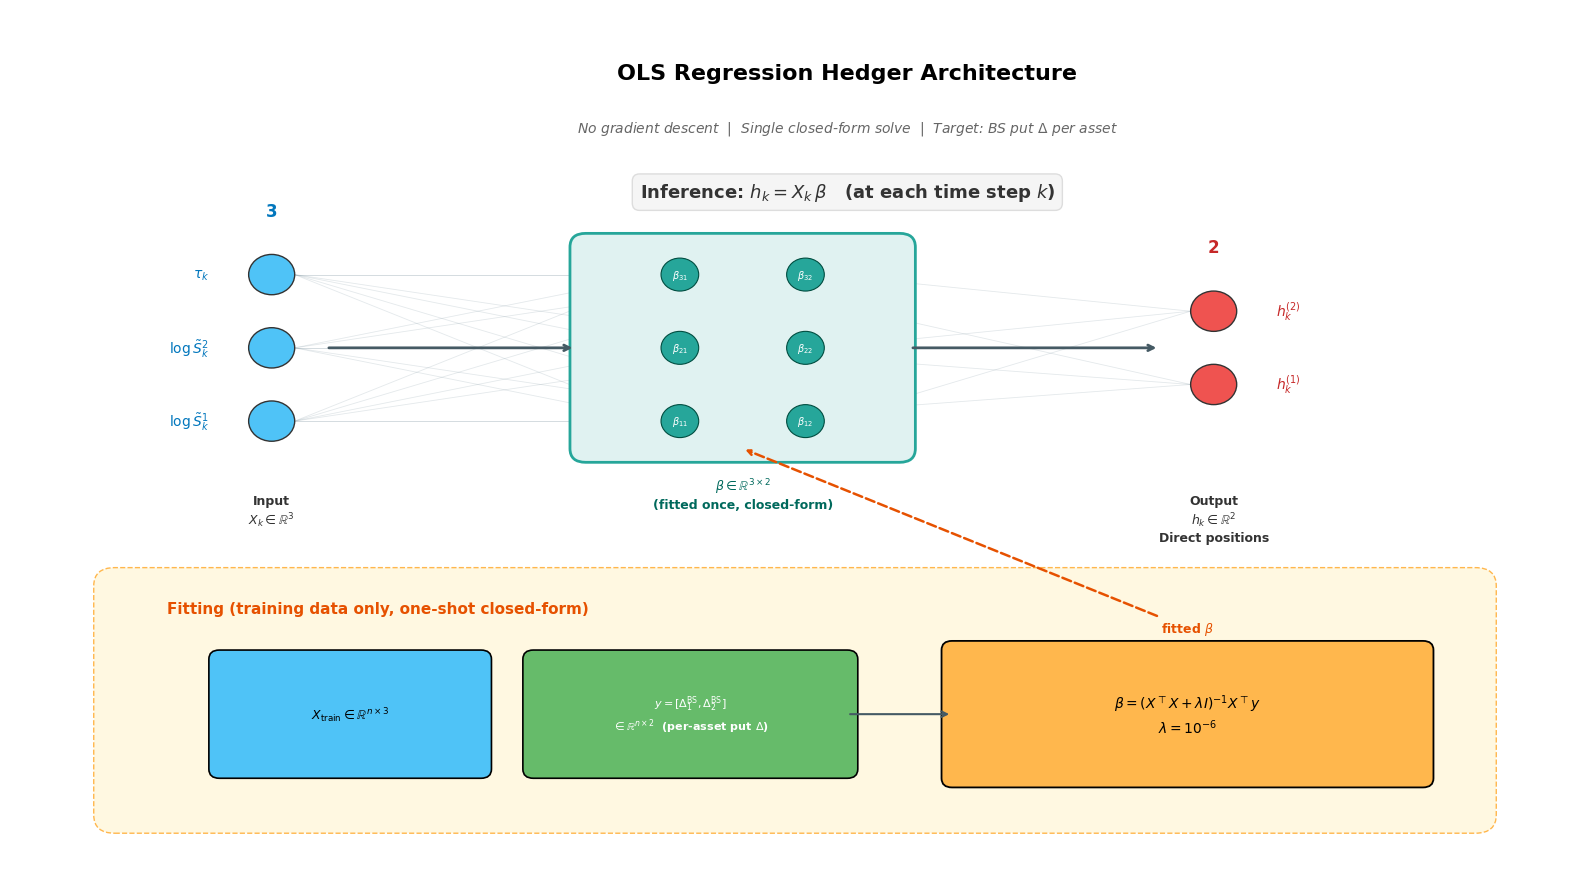

In [4]:
def draw_regression(save_path=None):
    """Draw the OLS Regression hedger with neuron-level diagram.
    
    Simple: 3 input neurons -> beta matrix (3x2) -> 2 output neurons.
    Also shows the fitting stage below.
    """
    fig, ax = plt.subplots(figsize=(16, 9))

    neuron_r = 0.22
    c_input = '#4FC3F7'
    c_beta = '#26A69A'
    c_output = '#EF5350'
    c_target = '#66BB6A'
    c_fit = '#FFB74D'
    c_conn = '#78909C'

    # ===== INFERENCE (top half) =====
    inf_label_y = 7.5
    ax.text(7.5, inf_label_y, 'Inference: $h_k = X_k \\, \\beta$   (at each time step $k$)',
            ha='center', va='center', fontsize=13, fontweight='bold', color='#333',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='#F5F5F5',
                     edgecolor='#DDD', linewidth=1.0))

    # Input neurons (3)
    inp_x = 2.0
    inp_ys = [5.0, 5.8, 6.6]
    inp_labels = ['$\\log \\tilde{S}_k^1$', '$\\log \\tilde{S}_k^2$', '$\\tau_k$']
    for y, lbl in zip(inp_ys, inp_labels):
        circle = plt.Circle((inp_x, y), neuron_r, facecolor=c_input,
                           edgecolor='#333', linewidth=1.0, zorder=3)
        ax.add_patch(circle)
        ax.text(inp_x - 0.6, y, lbl, ha='right', va='center', fontsize=10,
                fontweight='bold', color='#0277BD')

    ax.text(inp_x, 4.2, 'Input\n$X_k \\in \\mathbb{R}^3$', ha='center', va='top',
            fontsize=9, fontweight='bold', color='#333')
    ax.text(inp_x, inp_ys[-1] + 0.6, '3', ha='center', va='bottom',
            fontsize=12, fontweight='bold', color='#0277BD')

    # Beta matrix (shown as a grid of weights)
    beta_x = 6.5
    beta_y_center = 5.8
    beta_w = 3.0
    beta_h = 2.2

    # Draw beta matrix box
    beta_box = FancyBboxPatch((beta_x - beta_w/2, beta_y_center - beta_h/2),
                               beta_w, beta_h, boxstyle='round,pad=0.15',
                               facecolor='#E0F2F1', edgecolor=c_beta,
                               linewidth=2.0, zorder=1)
    ax.add_patch(beta_box)

    # Draw weight circles inside beta (3 rows x 2 cols)
    beta_xs = [beta_x - 0.6, beta_x + 0.6]
    beta_ys = [5.0, 5.8, 6.6]
    for row in range(3):
        for col in range(2):
            bx = beta_xs[col]
            by = beta_ys[row]
            wc = plt.Circle((bx, by), 0.18, facecolor=c_beta,
                           edgecolor='#004D40', linewidth=0.8, zorder=3)
            ax.add_patch(wc)
            ax.text(bx, by, f'$\\beta_{{{row+1}{col+1}}}$', ha='center', va='center',
                    fontsize=7, color='white', fontweight='bold', zorder=4)

    ax.text(beta_x, beta_y_center - beta_h/2 - 0.3,
            '$\\beta \\in \\mathbb{R}^{3 \\times 2}$\n(fitted once, closed-form)',
            ha='center', va='top', fontsize=9, fontweight='bold', color='#00695C')

    # Connections: input -> beta weights
    for iy in inp_ys:
        for col in range(2):
            for row in range(3):
                ax.plot([inp_x + neuron_r, beta_xs[col] - 0.18],
                        [iy, beta_ys[row]],
                        color=c_conn, linewidth=0.6, alpha=0.2, zorder=0)

    # Output neurons (2)
    out_x = 11.0
    out_ys = [5.4, 6.2]
    out_labels = ['$h_k^{(1)}$', '$h_k^{(2)}$']
    for y, lbl in zip(out_ys, out_labels):
        circle = plt.Circle((out_x, y), neuron_r, facecolor=c_output,
                           edgecolor='#333', linewidth=1.0, zorder=3)
        ax.add_patch(circle)
        ax.text(out_x + 0.6, y, lbl, ha='left', va='center', fontsize=10,
                fontweight='bold', color='#C62828')

    ax.text(out_x, 4.2, 'Output\n$h_k \\in \\mathbb{R}^2$\nDirect positions',
            ha='center', va='top', fontsize=9, fontweight='bold', color='#333')
    ax.text(out_x, out_ys[-1] + 0.6, '2', ha='center', va='bottom',
            fontsize=12, fontweight='bold', color='#C62828')

    # Connections: beta weights -> output
    for col in range(2):
        for row in range(3):
            ax.plot([beta_xs[col] + 0.18, out_x - neuron_r],
                    [beta_ys[row], out_ys[col]],
                    color=c_conn, linewidth=0.6, alpha=0.2, zorder=0)

    # Arrows
    ax.annotate('', xy=(beta_x - beta_w/2 - 0.1, beta_y_center),
                xytext=(inp_x + neuron_r + 0.3, beta_y_center),
                arrowprops=dict(arrowstyle='->', color='#455A64', lw=2))
    ax.annotate('', xy=(out_x - neuron_r - 0.3, beta_y_center),
                xytext=(beta_x + beta_w/2 + 0.1, beta_y_center),
                arrowprops=dict(arrowstyle='->', color='#455A64', lw=2))

    # ===== FITTING STAGE (bottom half) =====
    fit_y = 1.5
    fit_bg = FancyBboxPatch((0.5, fit_y - 0.8), 13, 2.5, boxstyle='round,pad=0.2',
                            facecolor='#FFF8E1', edgecolor='#FFB74D',
                            linewidth=1.0, linestyle='--', zorder=0)
    ax.add_patch(fit_bg)

    ax.text(1.0, fit_y + 1.4, 'Fitting (training data only, one-shot closed-form)',
            fontsize=11, fontweight='bold', color='#E65100')

    # Training X
    tx_box = FancyBboxPatch((1.5, fit_y - 0.3), 2.5, 1.2, boxstyle='round,pad=0.1',
                            facecolor=c_input, edgecolor='black', linewidth=1.2, zorder=1)
    ax.add_patch(tx_box)
    ax.text(2.75, fit_y + 0.3, '$X_{\\mathrm{train}} \\in \\mathbb{R}^{n \\times 3}$',
            ha='center', va='center', fontsize=9, fontweight='bold')

    # Target y
    ty_box = FancyBboxPatch((4.5, fit_y - 0.3), 3.0, 1.2, boxstyle='round,pad=0.1',
                            facecolor=c_target, edgecolor='black', linewidth=1.2, zorder=1)
    ax.add_patch(ty_box)
    ax.text(6.0, fit_y + 0.3,
            '$y = [\\Delta_1^{\\mathrm{BS}}, \\Delta_2^{\\mathrm{BS}}]$\n'
            '$\\in \\mathbb{R}^{n \\times 2}$  (per-asset put $\\Delta$)',
            ha='center', va='center', fontsize=8, fontweight='bold', color='white')

    # Arrow
    ax.annotate('', xy=(8.5, fit_y + 0.3), xytext=(7.5, fit_y + 0.3),
                arrowprops=dict(arrowstyle='->', color='#455A64', lw=1.5))

    # OLS formula
    ols_box = FancyBboxPatch((8.5, fit_y - 0.4), 4.5, 1.4, boxstyle='round,pad=0.1',
                             facecolor=c_fit, edgecolor='black', linewidth=1.3, zorder=1)
    ax.add_patch(ols_box)
    ax.text(10.75, fit_y + 0.3,
            '$\\beta = (X^\\top X + \\lambda I)^{-1} X^\\top y$\n'
            '$\\lambda = 10^{-6}$',
            ha='center', va='center', fontsize=10, fontweight='bold')

    # Arrow from OLS up to beta matrix
    ax.annotate('fitted $\\beta$',
                xy=(beta_x, beta_y_center - beta_h/2),
                xytext=(10.75, fit_y + 0.9 + 0.3),
                fontsize=9, color='#E65100', ha='center', fontweight='bold',
                arrowprops=dict(arrowstyle='->', color='#E65100', lw=1.8, linestyle='--'))

    # --- Title ---
    ax.text(7.5, 8.8, 'OLS Regression Hedger Architecture',
            ha='center', va='center', fontsize=16, fontweight='bold')
    ax.text(7.5, 8.2,
            'No gradient descent  |  Single closed-form solve  |  '
            'Target: BS put $\\Delta$ per asset',
            ha='center', va='center', fontsize=10, color='#666', style='italic')

    ax.set_xlim(-0.5, 14.5)
    ax.set_ylim(0.0, 9.5)
    ax.axis('off')
    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_regression('Figures/regression_architecture.png')

## 4. Side-by-Side Comparison

Summary of the three hedging models used in this thesis.

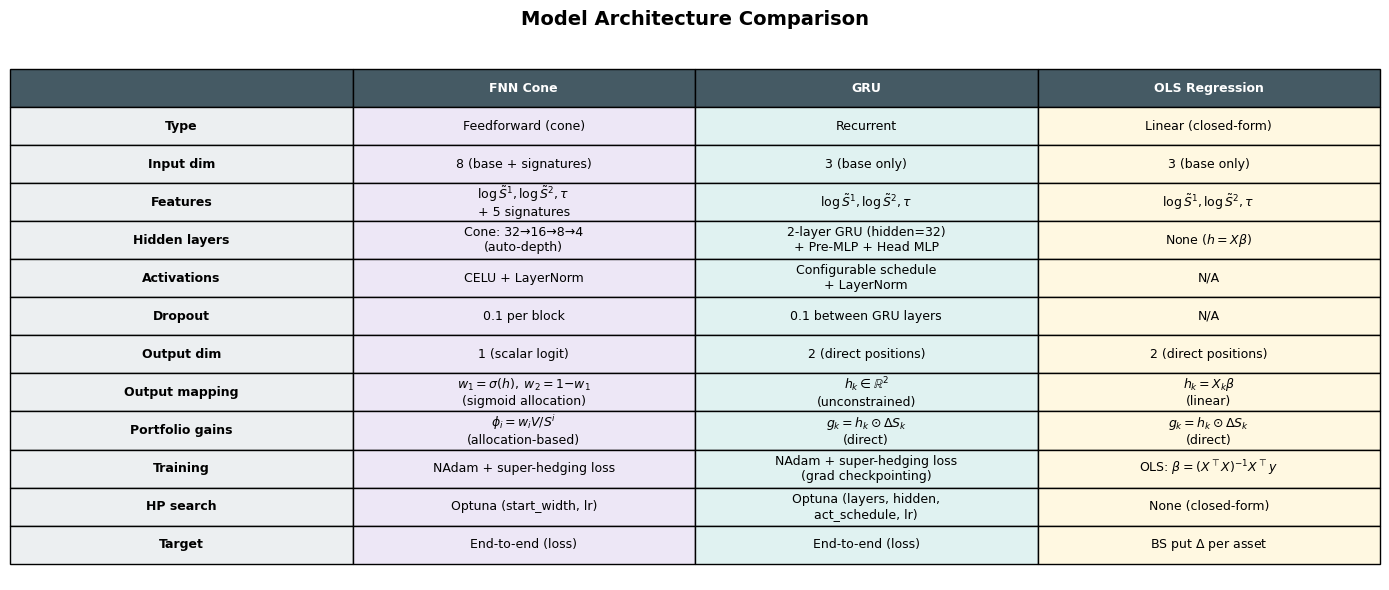

In [5]:
def draw_comparison_table(save_path=None):
    """Summary comparison figure of all three architectures."""
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.axis('off')

    headers = ['', 'FNN Cone', 'GRU', 'OLS Regression']
    rows = [
        ['Type', 'Feedforward (cone)', 'Recurrent', 'Linear (closed-form)'],
        ['Input dim', '8 (base + signatures)', '3 (base only)', '3 (base only)'],
        ['Features', '$\\log \\tilde{S}^1, \\log \\tilde{S}^2, \\tau$\n+ 5 signatures',
         '$\\log \\tilde{S}^1, \\log \\tilde{S}^2, \\tau$',
         '$\\log \\tilde{S}^1, \\log \\tilde{S}^2, \\tau$'],
        ['Hidden layers', 'Cone: 32→16→8→4\n(auto-depth)', '2-layer GRU (hidden=32)\n+ Pre-MLP + Head MLP',
         'None ($h = X\\beta$)'],
        ['Activations', 'CELU + LayerNorm', 'Configurable schedule\n+ LayerNorm', 'N/A'],
        ['Dropout', '0.1 per block', '0.1 between GRU layers', 'N/A'],
        ['Output dim', '1 (scalar logit)', '2 (direct positions)', '2 (direct positions)'],
        ['Output mapping', '$w_1 = \\sigma(h),\\; w_2 = 1{-}w_1$\n(sigmoid allocation)',
         '$h_k \\in \\mathbb{R}^2$\n(unconstrained)', '$h_k = X_k \\beta$\n(linear)'],
        ['Portfolio gains', '$\\phi_i = w_i V / S^i$\n(allocation-based)',
         '$g_k = h_k \\odot \\Delta S_k$\n(direct)', '$g_k = h_k \\odot \\Delta S_k$\n(direct)'],
        ['Training', 'NAdam + super-hedging loss', 'NAdam + super-hedging loss\n(grad checkpointing)',
         'OLS: $\\beta = (X^\\top X)^{-1}X^\\top y$'],
        ['HP search', 'Optuna (start_width, lr)', 'Optuna (layers, hidden,\nact_schedule, lr)',
         'None (closed-form)'],
        ['Target', 'End-to-end (loss)', 'End-to-end (loss)', 'BS put $\\Delta$ per asset'],
    ]

    table = ax.table(
        cellText=rows,
        colLabels=headers,
        loc='center',
        cellLoc='center',
    )
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.0, 2.0)

    # Style header
    for j in range(len(headers)):
        cell = table[0, j]
        cell.set_text_props(fontweight='bold', color='white')
        cell.set_facecolor('#455A64')

    # Column colours (light tints)
    col_colours = {1: '#EDE7F6', 2: '#E0F2F1', 3: '#FFF8E1'}  # purple, teal, amber tints

    # Style row labels and cells
    for i in range(1, len(rows) + 1):
        cell = table[i, 0]
        cell.set_text_props(fontweight='bold')
        cell.set_facecolor('#ECEFF1')
        for j in range(1, len(headers)):
            cell = table[i, j]
            cell.set_facecolor(col_colours.get(j, '#FFFFFF'))

    ax.set_title('Model Architecture Comparison', fontsize=14, fontweight='bold', pad=20)

    fig.tight_layout()
    if save_path:
        fig.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()

draw_comparison_table('Figures/model_comparison_table.png')